# Imports

In [41]:
import polars as pl
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from matplotlib import pyplot as plt
from typing import List
import pandas as pd
from sklearn.metrics import ndcg_score

import numpy as np
from sklearn.metrics import ndcg_score


# Parameters

In [42]:
label_column = "has_seen_venue_in_this_session"
pred_label = f"pred_{label_column}"
group_column = "session_id_hashed"
rank_column = "popularity"
rank_pos_column = "position_in_list"
predicted_rank_column = f"predicted_{rank_column}"
features = [
    'venue_id',
 'conversions_per_impression',
#  "purchased",
#  'price_range',
 'rating',
 'popularity',
 'retention_rate',
 'session_id_hashed',
 'position_in_list',
#  'has_seen_venue_in_this_session',
#  'is_new_user',
 'is_from_order_again',
 'is_recommended']
metric_columns = ["baseline_ndcg", "model_ndcg"]

# Utils

In [43]:
def convert_boolean_to_int(ranking_data):
    bool_cols = ranking_data.select(pl.col(pl.Boolean)).columns
    ranking_data = ranking_data.with_columns(
        [
            pl.col(column).cast(pl.Int8, strict=False).alias(column)
            for column in bool_cols
            ]
        )
    return ranking_data
def plot_lgb_report(lgb_model, evals_logs: dict, eval_at = [10, 20, 40]):
    for k in eval_at:
        fig, ax = plt.subplots(figsize=(12, 8))
        lgb.plot_metric(evals_logs, ax=ax, metric=f"ndcg@{k}")

        
    lgb.plot_importance(lgb_model, importance_type="gain", figsize=(14, 8))
    lgb.plot_importance(lgb_model, importance_type="split", figsize=(14, 8))
        
def qa_features(model: lgb, features: List[str]):
    feature_importance = {
        feature: importance
        for feature, importance in zip(
        model.feature_name(), model.feature_importance()
        )
    }
    print(feature_importance)
    used_features = [
        f for f in feature_importance
        if feature_importance[f] != 0
    ]
    dropped_features = [f for f in features if f not in used_features]
    print("-------------------------------------------------------")
    print("Used features: ")
    print(used_features)
    print("-------------------------------------------------------")
    print(
        f"passed {len(features)} "
        f"features and model used {len(used_features)} of them"
    )
    print("-------------------------------------------------------")
    print(f"these features were dropped: {dropped_features}")
    return used_features

def generate_predictions(
    test_set: pl.DataFrame, model: lgb, features_to_use: List[str]
) -> pd.DataFrame:
    test_set_pandas = test_set.sort(
        by=[group_column, rank_column], reverse=False
    ).to_pandas()
    test_set_pandas[features_to_use] = test_set_pandas[features_to_use].fillna(0)
    test_x = test_set_pandas[features_to_use]

    test_set_pandas[pred_label] = model.predict(test_x)
    test_set_pandas[predicted_rank_column] = (
        test_set_pandas.groupby(group_column)[pred_label]
        .rank(method="first", ascending=False)
        .astype(int)
    )
    return test_set_pandas
def drop_sessions_with_no_interactions(ranking_data):
    active_sessions = (
        ranking_data
        .filter(pl.col(label_column)==1)
        .select("session_id","position_in_list", "popularity").sort("session_id").groupby("session_id").count().sort("count")\
        .filter(pl.col("count")>1).select("session_id")
    )
    active_ranking_data = ranking_data.join(active_sessions, on="session_id")

    return active_ranking_data
def calculate_ndcg_score(y_true: pl.Series, y_pred:pl.Series):
    return pl.Series([ndcg_score(y_true=y_true, y_score=y_pred)], dtype=pl.Float64)


def my_ndcg(y_true, y_pred):
    y_true = np.asarray([y_true])
    y_pred = np.asarray([y_pred])
    return ndcg_score(y_true=y_true, y_score = y_pred)
def relative_percentage_increase(baseline_value, model_value):
    baseline_value = np.asarray(baseline_value)
    model_value = np.asarray(model_value)
    return (model_value - baseline_value)/baseline_value * 100


# Prepare data

## Read raw data

In [44]:
%%time
sessions = pl.read_csv("../sessions.csv")
sessions = sessions.drop_nulls()
venues = pl.read_csv("../venues.csv")
venues = venues.drop_nulls()

CPU times: user 1.38 s, sys: 1.62 s, total: 2.99 s
Wall time: 1.12 s


## Join venue data with search data

In [45]:
ranking_data = sessions.join(venues, on="venue_id")
ranking_data = convert_boolean_to_int(ranking_data)
# hex_string = "0a21dde9-1495-417c-bb9d-9922b81f2e6a"


ranking_data = ranking_data.with_column(
    pl.col("session_id").str.replace("-","").alias("session_id_hashed").hash(seed=0)
)



/tmp/ipykernel_8270/3514575546.py:6: DeprecationWarning: `DataFrame.with_column` has been renamed; this redirect is temporary, please use `.with_columns` instead
  ranking_data = ranking_data.with_column(


# Split data into train, val and test

In [46]:
train_set, unseen_set = train_test_split(ranking_data, train_size=0.2, test_size=0.8)
val_set, test_set = train_test_split(unseen_set, train_size=0.2, test_size=0.8)

In [47]:
train_set.shape, val_set.shape, test_set.shape

((232757, 16), (186206, 16), (744825, 16))

## Check results are sorted by popularity

In [48]:
train_set.sort(by=[group_column, rank_column], reverse=True).head(10)

,purchased,session_id,position_in_list,venue_id,has_seen_venue_in_this_session,is_new_user,is_from_order_again,is_recommended,_right,conversions_per_impression,price_range,rating,popularity,retention_rate,session_id_hashed
i64,i8,str,i64,i64,i8,i8,i8,i8,i64,f64,i64,f64,f64,f64,u64
12732706,0,"""B6F51141-5CEA-...",150,131802517042376614,0,0,0,0,902,0.206568,2,9.0,18.994495,0.503247,18446336676963598362
12732711,0,"""B6F51141-5CEA-...",155,2825547941213419305,0,0,0,1,469,0.09218,4,8.8,10.233847,0.189786,18446336676963598362
12732626,0,"""B6F51141-5CEA-...",70,-891158643077214109,0,0,0,0,322,0.289196,1,8.8,9.762086,0.38196,18446336676963598362
12732647,0,"""B6F51141-5CEA-...",91,7933826470430062978,0,0,0,0,473,0.175809,2,9.0,8.612243,0.189258,18446336676963598362
12732794,0,"""B6F51141-5CEA-...",238,-4494850454474302466,0,0,0,0,313,0.274199,2,9.2,8.59416,0.261252,18446336676963598362
12732616,0,"""B6F51141-5CEA-...",60,-6498931179224101116,0,0,0,0,803,0.291209,1,8.2,6.306666,0.320532,18446336676963598362
12732831,0,"""B6F51141-5CEA-...",275,-3915295221462934484,0,0,0,0,376,0.151685,2,9.0,6.160919,0.2974335,18446336676963598362
12732806,0,"""B6F51141-5CEA-...",250,-2412717386613579663,0,0,0,0,720,0.265996,3,9.0,5.662352,0.253662,18446336676963598362
12732686,0,"""B6F51141-5CEA-...",130,7437834897193564357,0,0,0,0,300,0.094477,2,9.2,4.690807,0.2229225,18446336676963598362


# prepare datasets

In [49]:
train_set = train_set.sort(by=[group_column, rank_column], reverse=False)
train_set_group_sizes = (
    train_set.groupby(group_column)
    .agg(pl.col(group_column).count().alias("count"))
    .sort(group_column)
    .select("count")
)

val_set = val_set.sort(by=[group_column, rank_column], reverse=False)
val_set_group_sizes = (
    val_set.groupby(group_column)
    .agg(pl.col(group_column).count().alias("count"))
    .sort(group_column)
    .select("count")
)

In [50]:
%%time

train_y = train_set[[label_column]]
train_x = train_set[features]

val_y = val_set[[label_column]]
val_x = val_set[features]

test_x = test_set[features]

lgb_train_set = lgb.Dataset(
    train_x.to_pandas(),
    label=train_y.to_pandas(),
    group=train_set_group_sizes.to_numpy(),
    free_raw_data=True
).construct()

lgb_valid_set = lgb.Dataset(
    val_x.to_pandas(),
    label=val_y.to_pandas(),
    group=val_set_group_sizes.to_numpy(),
    reference=lgb_train_set,
    free_raw_data=True
).construct()

del train_y
del train_x

import gc

gc.collect()

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


CPU times: user 903 ms, sys: 0 ns, total: 903 ms
Wall time: 561 ms


19676

## check distribution for selected event occurence

In [51]:
from collections import Counter
label_freq = Counter(ranking_data[label_column].to_numpy())
print(label_freq)
label_freq[1]/ranking_data.shape[0] * 100

Counter({0: 1069742, 1: 94046})


8.081025066421033

# Train

## fix lgb params

In [52]:
lgb_params = {
    "objective": "lambdarank",
    "num_leaves": 100,
    "min_sum_hessian_in_leaf": 10,
    "metric": "ndcg",
    "ndcg_eval_at": [10, 20, 40],
    "learning_rate": 0.8,
    "force_row_wise": True,
    "num_iterations": 2,
}


In [53]:
%%time

evals_logs = {}

lgb_model = lgb.train(
    params=lgb_params,
    train_set=lgb_train_set,
    valid_sets=[lgb_valid_set, lgb_train_set],
    valid_names=["val", "train"],
    verbose_eval=25,
    evals_result=evals_logs,
    early_stopping_rounds=25
)

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:260: UserWarning: 

[LightGBM] [Info] Total Bins 1545
[LightGBM] [Info] Number of data points in the train set: 232757, number of used features: 9
Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[2]	train's ndcg@10: 0.989017	train's ndcg@20: 0.991336	train's ndcg@40: 0.991337	val's ndcg@10: 0.984328	val's ndcg@20: 0.986811	val's ndcg@40: 0.986634
CPU times: user 899 ms, sys: 19.6 ms, total: 919 ms
Wall time: 260 ms


# QA

## plot the metrics

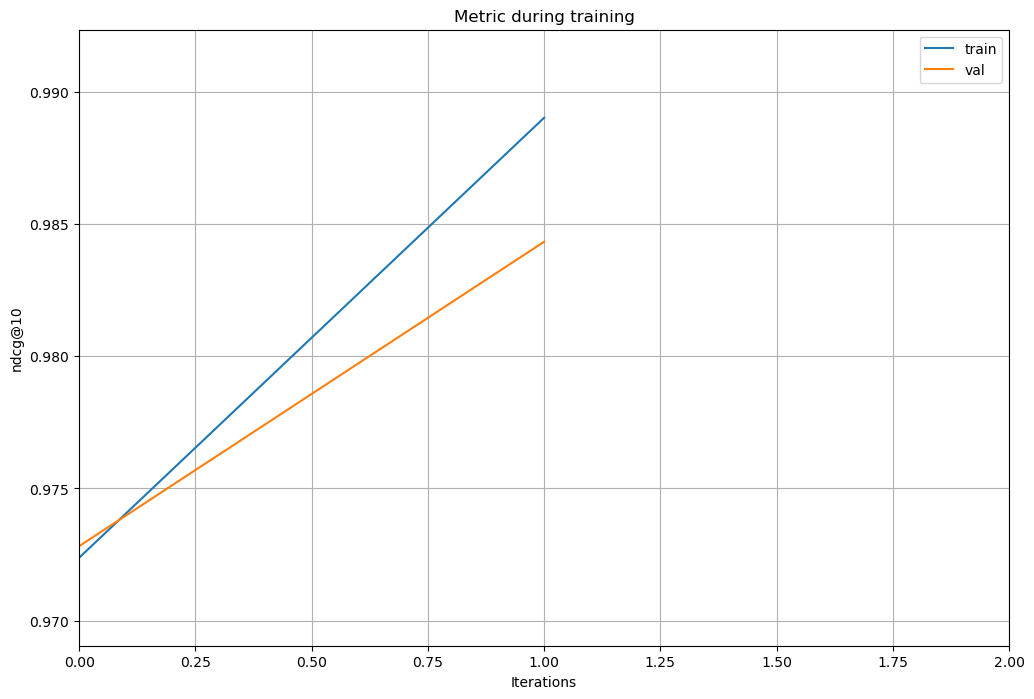

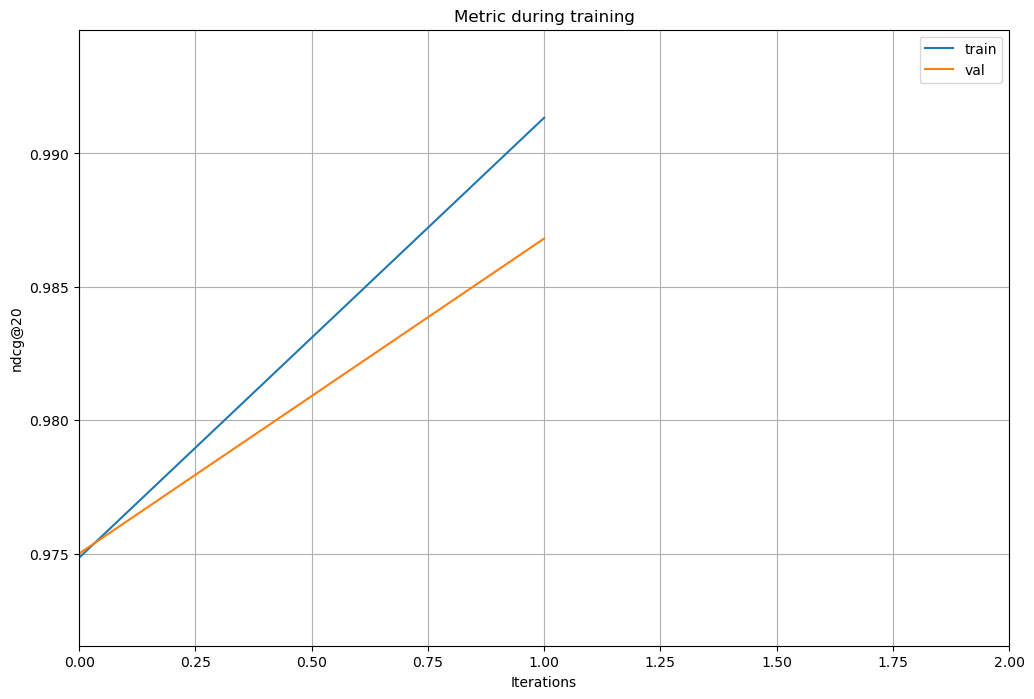

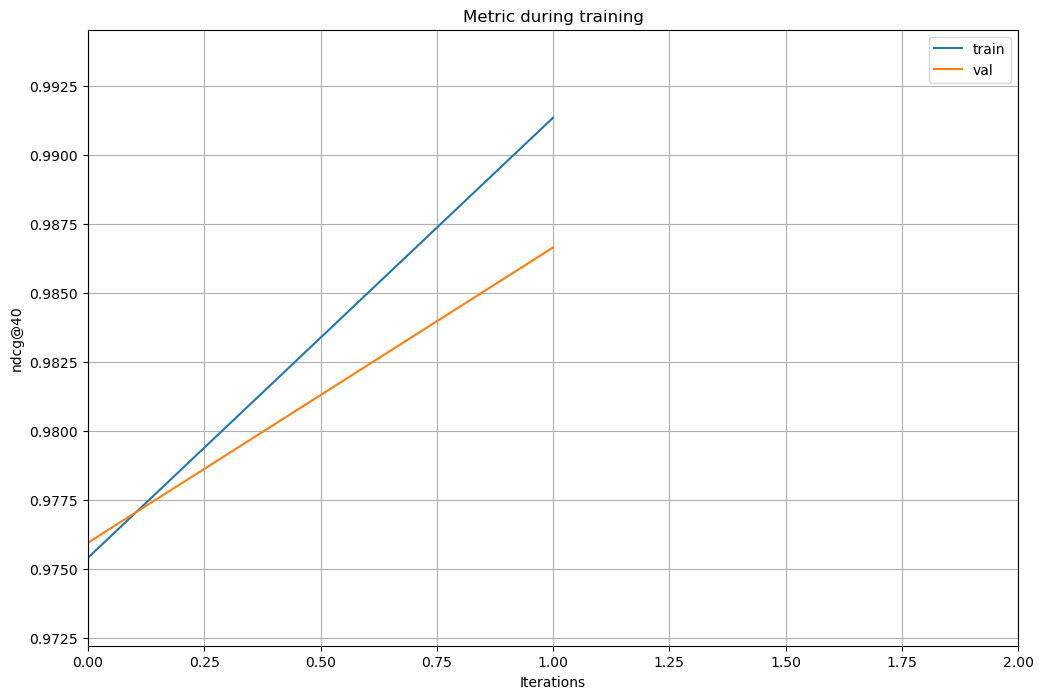

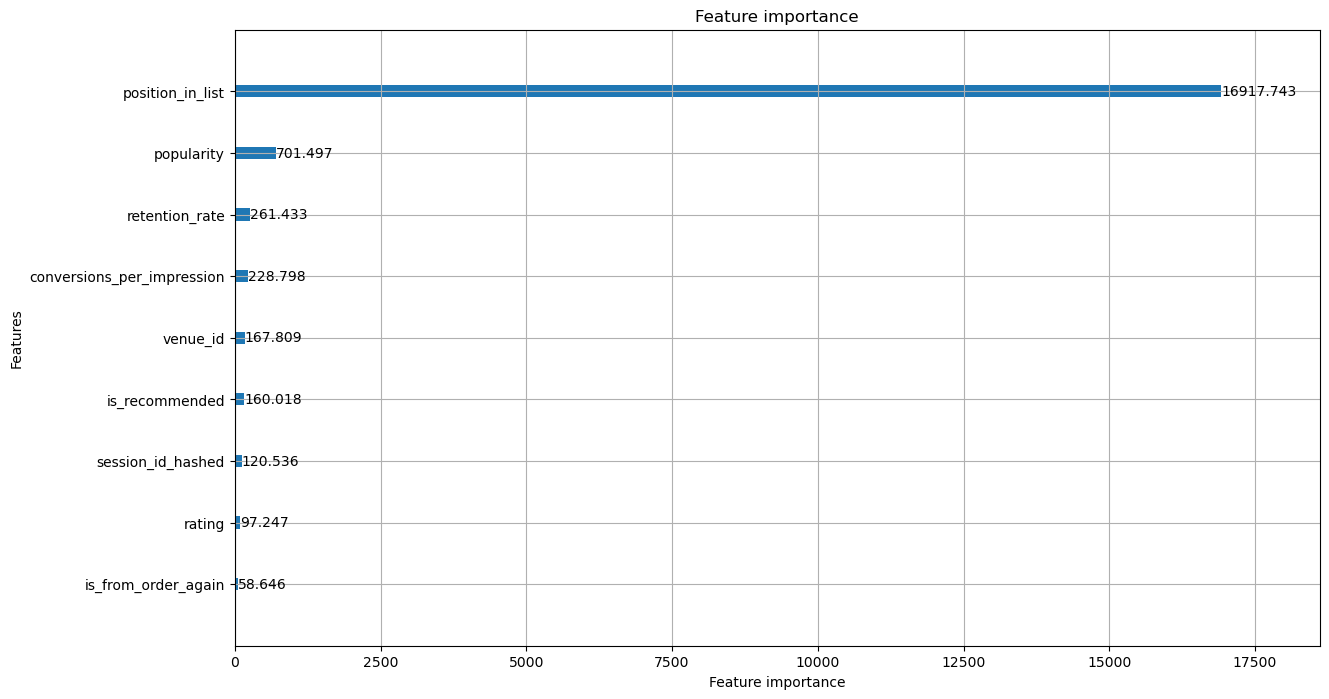

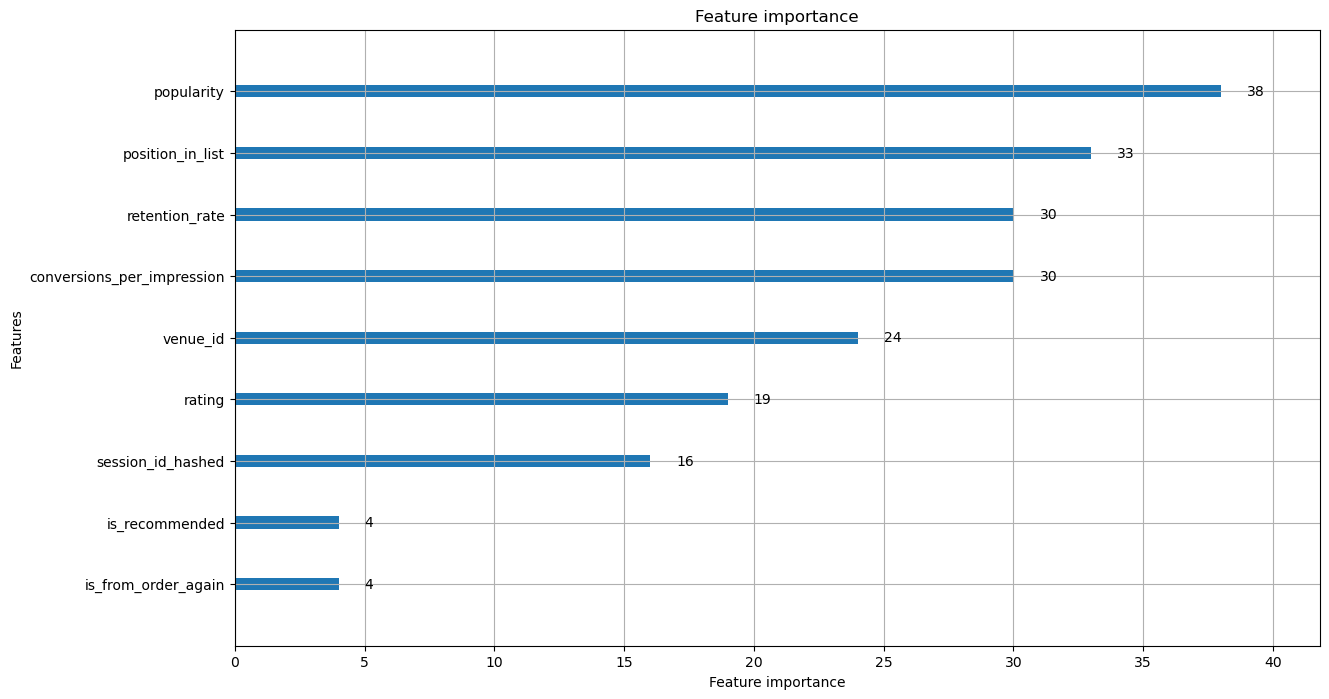

In [54]:
plot_lgb_report(lgb_model, evals_logs)

In [55]:
used_features = qa_features(lgb_model, features)

{'venue_id': 24, 'conversions_per_impression': 30, 'rating': 19, 'popularity': 38, 'retention_rate': 30, 'session_id_hashed': 16, 'position_in_list': 33, 'is_from_order_again': 4, 'is_recommended': 4}
-------------------------------------------------------
Used features: 
['venue_id', 'conversions_per_impression', 'rating', 'popularity', 'retention_rate', 'session_id_hashed', 'position_in_list', 'is_from_order_again', 'is_recommended']
-------------------------------------------------------
passed 9 features and model used 9 of them
-------------------------------------------------------
these features were dropped: []


In [56]:
assert used_features == features

# save the trained model

In [57]:
%%time
lgb_model.save_model("/tmp/venues_ranking.pkl")

CPU times: user 5.24 ms, sys: 2.62 ms, total: 7.86 ms
Wall time: 4.37 ms


## check sorting of rank positions for the event: attended the venue

In [58]:
(
    ranking_data
    # .filter(pl.col("session_id_hashed")==2697534841382868)
    .sort(by=[group_column, rank_column], reverse=False)
    .groupby("session_id")
    .agg(
        pl.all().take([0,1, 2])
    )
    .explode("rating").head(10)
)

session_id,,purchased,position_in_list,venue_id,has_seen_venue_in_this_session,is_new_user,is_from_order_again,is_recommended,_right,conversions_per_impression,price_range,rating,popularity,retention_rate,session_id_hashed
str,list[i64],list[i8],list[i64],list[i64],list[i8],list[i8],list[i8],list[i8],list[i64],list[f64],list[i64],f64,list[f64],list[f64],list[u64]
"""AB3BD56E-B5D9-...","[3677606, 3677653, 3677658]","[0, 0, 0]","[77, 124, 129]","[3257242292074930225, 6994327881557323832, 5976932403723417814]","[1, 0, 0]","[0, 0, 0]","[0, 1, 0]","[0, 0, 0]","[398, 726, 729]","[0.0, 0.052632, 0.05632]","[2, 1, 2]",8.8,"[0.0, 0.0, 0.0]","[0.214286, 0.0, 0.321429]","[2157172437218095825, 2157172437218095825, 2157172437218095825]"
"""AB3BD56E-B5D9-...","[3677606, 3677653, 3677658]","[0, 0, 0]","[77, 124, 129]","[3257242292074930225, 6994327881557323832, 5976932403723417814]","[1, 0, 0]","[0, 0, 0]","[0, 1, 0]","[0, 0, 0]","[398, 726, 729]","[0.0, 0.052632, 0.05632]","[2, 1, 2]",9.0,"[0.0, 0.0, 0.0]","[0.214286, 0.0, 0.321429]","[2157172437218095825, 2157172437218095825, 2157172437218095825]"
"""AB3BD56E-B5D9-...","[3677606, 3677653, 3677658]","[0, 0, 0]","[77, 124, 129]","[3257242292074930225, 6994327881557323832, 5976932403723417814]","[1, 0, 0]","[0, 0, 0]","[0, 1, 0]","[0, 0, 0]","[398, 726, 729]","[0.0, 0.052632, 0.05632]","[2, 1, 2]",9.0,"[0.0, 0.0, 0.0]","[0.214286, 0.0, 0.321429]","[2157172437218095825, 2157172437218095825, 2157172437218095825]"
"""015bacbc-b21a-...","[23797, 23820, 23834]","[0, 0, 0]","[44, 67, 81]","[6994327881557323832, -1012604272228201392, -7194483610396448471]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[726, 733, 860]","[0.052632, 0.019934, 0.007538]","[1, 2, 1]",9.0,"[0.0, 0.0, 0.0]","[0.0, 0.333333, 0.0]","[4951977983503919536, 4951977983503919536, 4951977983503919536]"
"""015bacbc-b21a-...","[23797, 23820, 23834]","[0, 0, 0]","[44, 67, 81]","[6994327881557323832, -1012604272228201392, -7194483610396448471]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[726, 733, 860]","[0.052632, 0.019934, 0.007538]","[1, 2, 1]",8.6,"[0.0, 0.0, 0.0]","[0.0, 0.333333, 0.0]","[4951977983503919536, 4951977983503919536, 4951977983503919536]"
"""015bacbc-b21a-...","[23797, 23820, 23834]","[0, 0, 0]","[44, 67, 81]","[6994327881557323832, -1012604272228201392, -7194483610396448471]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[726, 733, 860]","[0.052632, 0.019934, 0.007538]","[1, 2, 1]",9.0,"[0.0, 0.0, 0.0]","[0.0, 0.333333, 0.0]","[4951977983503919536, 4951977983503919536, 4951977983503919536]"
"""1CB0B2A7-681E-...","[5726384, 5726575, 5726603]","[0, 0, 0]","[119, 310, 338]","[1701525175334756094, 5976932403723417814, -5505329314095346616]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[168, 729, 499]","[0.003067, 0.05632, 0.0]","[2, 2, 2]",9.0,"[0.0, 0.0, 0.0]","[0.3, 0.321429, 0.15]","[5066736576292789124, 5066736576292789124, 5066736576292789124]"
"""1CB0B2A7-681E-...","[5726384, 5726575, 5726603]","[0, 0, 0]","[119, 310, 338]","[1701525175334756094, 5976932403723417814, -5505329314095346616]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[168, 729, 499]","[0.003067, 0.05632, 0.0]","[2, 2, 2]",9.0,"[0.0, 0.0, 0.0]","[0.3, 0.321429, 0.15]","[5066736576292789124, 5066736576292789124, 5066736576292789124]"
"""1CB0B2A7-681E-...","[5726384, 5726575, 5726603]","[0, 0, 0]","[119, 310, 338]","[1701525175334756094, 5976932403723417814, -5505329314095346616]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[168, 729, 499]","[0.003067, 0.05632, 0.0]","[2, 2, 2]",8.8,"[0.0, 0.0, 0.0]","[0.3, 0.321429, 0.15]","[5066736576292789124, 5066736576292789124, 5066736576292789124]"


# prepare predictions on test for quality assurance

In [59]:
predictions = generate_predictions(test_set, lgb_model, features_to_use=features)
predictions_pl = pl.DataFrame(predictions)
active_ranking_data = drop_sessions_with_no_interactions(predictions_pl)
active_ranking_data.head(10)

column_0,purchased,session_id,position_in_list,venue_id,has_seen_venue_in_this_session,is_new_user,is_from_order_again,is_recommended,_right,conversions_per_impression,price_range,rating,popularity,retention_rate,session_id_hashed,pred_has_seen_venue_in_this_session,predicted_popularity
i64,i8,str,i64,i64,i8,i8,i8,i8,i64,f64,i64,f64,f64,f64,u64,f64,i64
12099587,0,"""D9D4977A-97A9-...",133,-9076052207444688139,0,0,1,0,409,0.0,2,8.6,0.0,0.0,2697534841382868,-2.409219,104
12099535,0,"""D9D4977A-97A9-...",81,472199130850792437,0,0,0,0,250,0.026087,1,9.0,0.0,1.0,2697534841382868,-1.490401,55
12099563,0,"""D9D4977A-97A9-...",109,-1012604272228201392,0,0,0,0,733,0.019934,2,8.6,0.0,0.333333,2697534841382868,-2.151501,102
12099581,0,"""D9D4977A-97A9-...",127,3257242292074930225,0,0,0,0,398,0.0,2,8.8,0.0,0.214286,2697534841382868,-2.140558,98
12099500,0,"""D9D4977A-97A9-...",46,6994327881557323832,0,0,1,0,726,0.052632,1,9.0,0.0,0.0,2697534841382868,-1.307084,48
12099623,0,"""D9D4977A-97A9-...",169,-5723001116090356006,0,0,0,0,1132,0.017143,3,9.0,0.0,0.1000005,2697534841382868,-2.409219,105
12099626,0,"""D9D4977A-97A9-...",172,8555011602643323738,0,0,0,0,517,0.084507,2,8.6,0.039362,0.6,2697534841382868,-2.409219,106
12099530,0,"""D9D4977A-97A9-...",76,6232322477246922987,0,0,1,0,433,0.035461,2,9.0,0.098332,0.272727,2697534841382868,-0.630292,31
12099532,0,"""D9D4977A-97A9-...",78,8220935099878472881,0,0,0,0,682,0.069124,2,7.6,0.125688,0.193548,2697534841382868,-0.791431,35


In [60]:
active_ranking_data.groupby("session_id").count().sort("count", reverse=True).head(10)

session_id,count
str,u32
"""eac7cdc2-6047-...",1318
"""f5bc3cc1-bcd1-...",1293
"""922817cf-06eb-...",1283
"""de874ff2-9db1-...",1265
"""b8954892-7082-...",1247
"""ed1ad14a-a2d2-...",1183
"""7bc8e07c-951b-...",1154
"""8cc2d8c1-1e74-...",1110
"""fc6f48be-0acb-...",1096


## compute baseline metrics: ndcg

In [61]:
%%time
baseline_ndcg_per_sessions = (
    active_ranking_data
    .filter(pl.col(label_column)==1)
    .groupby("session_id")
    .agg([
        pl.apply(
            [pl.col('position_in_list'), pl.col("popularity")], lambda s: my_ndcg(s[0],s[1]) ).alias('baseline_ndcg')
    ])
)

CPU times: user 747 ms, sys: 0 ns, total: 747 ms
Wall time: 701 ms


## compute model metrics: ndcg

In [62]:
%%time
model_ndcg_per_sessions = (
    active_ranking_data
    .filter(pl.col(label_column)==1)
    .groupby("session_id")
    .agg([
        pl.apply(
            [pl.col('position_in_list'), pl.col("predicted_popularity")], lambda s: my_ndcg(s[0],s[1]) ).alias('model_ndcg')
    ])
)

CPU times: user 713 ms, sys: 0 ns, total: 713 ms
Wall time: 660 ms


In [63]:
pl.apply([pl.col('baseline_ndcg'), pl.col("model_ndcg")], lambda s: relative_percentage_increase(s[0],s[1]) ).alias('ndcg_percentage_diff')


In [1]:
relative_percentage_increase

NameError: name 'relative_percentage_increase' is not defined

## join and compare metrics: baseline vs model

In [64]:
predictions_pl.join(baseline_ndcg_per_sessions, on="session_id").join(model_ndcg_per_sessions, on="session_id")[ used_features + metric_columns].with_columns(
    [
        pl.apply([pl.col('baseline_ndcg'), pl.col("model_ndcg")], lambda s: relative_percentage_increase(s[0],s[1]) ).alias('ndcg_percentage_diff')

    ]
).head(2)

: 

: 